In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ICU')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from neural_network_decision_tree import nn_decision_tree
import pandas as pd

In [3]:
np.random.seed(1943)
tf.random.set_seed(1943)

In [4]:
dataset = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

In [5]:
age = pd.get_dummies(dataset['AGE_PERCENTIL'],drop_first=True)
window = pd.get_dummies(dataset['WINDOW'],drop_first=True)
dataset.drop(['AGE_PERCENTIL','WINDOW'],axis=1,inplace=True)
dataset = pd.concat([dataset,age,window],axis=1)

In [6]:
dl = int(len(dataset)/5)
cl = int(len(dataset.columns))

In [7]:
for i in range(dl):
  for j in range(cl):
    mean = dataset.iloc[i*5:((i+1)*5),j].mean()
    for k,l in enumerate(dataset.iloc[i*5:((i+1)*5),j].isnull()):
      if l == True:
        dataset.loc[i*5:(i+1)*5,dataset.columns[j]].values[k] = mean

In [8]:
x = dataset[['GENDER','OXYGEN_SATURATION_DIFF_REL']]
y = pd.Series.to_frame(dataset["ICU"])
d = x.shape[1]

In [9]:
num_cut = [1, 1]  
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 1

In [10]:
sess = tf.compat.v1.InteractiveSession()

In [11]:
tf.compat.v1.disable_eager_execution()
x_ph = tf.compat.v1.placeholder(tf.float32, [None, d])
y_ph = tf.compat.v1.placeholder(tf.float32, [None, num_class])

In [12]:
cut_points_list = [tf.Variable(tf.random.uniform([i])) for i in num_cut]
leaf_score = tf.Variable(tf.random.uniform([num_leaf, num_class]))

In [13]:
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)
loss = tf.reduce_mean(tf.compat.v1.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))

In [14]:
opt = tf.compat.v1.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

In [15]:
sess.run(tf.compat.v1.global_variables_initializer())

In [16]:
for i in range(1000):
    _, loss_e = sess.run([train_step, loss], feed_dict={x_ph: x, y_ph: y})
    if i % 200 == 0:
        print(loss_e)
print('error rate %.2f' % (1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1) == np.argmax(y.to_numpy(), axis=1))))

nan
nan
nan
nan
nan
error rate 0.00


In [17]:
sample_x0 = np.repeat(np.linspace(0, np.max(x.iloc[:,0]), 100), 100).reshape(-1,1)
sample_x1 = np.tile(np.linspace(0, np.max(x.iloc[:,1]), 100).reshape(-1,1), [100,1])
sample_x = np.hstack([sample_x0, sample_x1])
sample_label = np.argmax(y_pred.eval(feed_dict={x_ph: sample_x}), axis=1)

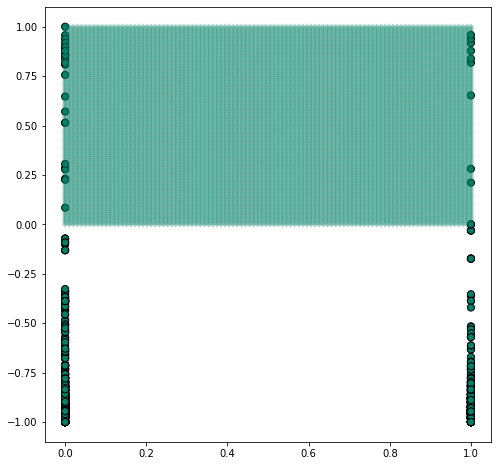

In [18]:

plt.figure(figsize=(8,8))

plt.scatter(x.iloc[:,0], 
            x.iloc[:,1], 
            c=np.argmax(y.to_numpy(), axis=1), 
            marker='o',
            s=50,
            cmap='summer', 
            edgecolors='black'
            )

plt.scatter(sample_x0.flatten(), 
            sample_x1.flatten(), 
            c=sample_label.flatten(), 
            marker='D',
            s=20,
            cmap='summer', 
            edgecolors='none',
            alpha=0.33)